# RETREAT workflow - CENTERLINE

In [1]:
import json
import pystac
import stackstac
import os
import xarray as xr
import geopandas as gpd
from shapely import Polygon
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rio
from rasterio.crs import CRS
import rasterio 
import matplotlib.patches as mpatches
import numpy as np
from scipy.stats import sem

In [2]:
import sys
sys.path.insert(0, '/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/retreat/')

import retreat_tools
import itslive_tools
import general_tools

## Utility fns

## Read in STAC catalog, explore metadata

In [115]:
catalog = pystac.Catalog.from_file('/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/324stac_catalog/catalog.json')


In [116]:
catalog

"ID: RETREAT data, Langtang"
Description: NEW RETREAT velocity data for glaciers in Langtang region of Nepal/Tibet
type: Catalog
https://stac-extensions.github.io/projection/v1.0.0/schema.json
ID: 10_085_053_20210113
"Bounding Box: [83.90435612095534, 27.316552327766512, 86.84688658910103, 29.3949542892891]"
Datetime: 2021-01-13 00:00:00+00:00
tile: 10_085_053
sensor: S1
img1_date: 20210107T122220
img1_id: BFF8


In [117]:
items = list(catalog.get_all_items())

In [118]:
for item in items:
    
    retreat_tools.check_orig_files(item)

In [119]:
feature_coll = [item.to_dict() for item in items]

In [120]:
gdf = gpd.GeoDataFrame.from_features(feature_coll)

In [121]:
gdf = gdf.set_crs('EPSG:4326')
gdf_prj = gdf.to_crs('EPSG:32645')

<AxesSubplot: >

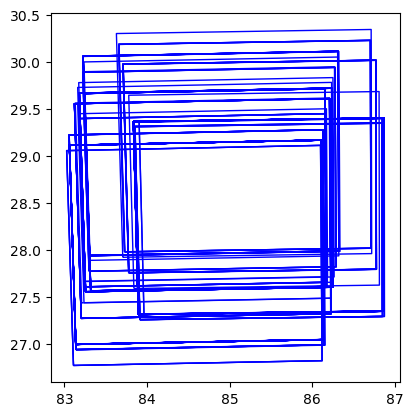

In [122]:
gdf.plot(facecolor='None', edgecolor='blue')

## Explore RETREAT data

In [214]:
cube = stackstac.stack(
    items = [item.to_dict() for item in items])

In [215]:
def cube_process(cube):
    
    cube['img1_dt'] = (('time'), pd.to_datetime(cube.img1_date))
    cube['img2_dt'] = (('time'), pd.to_datetime(cube.img2_date))
    
    cube['img_separation'] = (cube.img1_dt - cube.img2_dt).astype('timedelta64[D]') / np.timedelta64(1,'D')

    cube = cube.drop(['img1_date','img2_date'])
    
    cube = cube.rename({'img1_dt':'img1_date',
                        'img2_dt':'img2_date'})
    return  cube

In [216]:
cube = cube_process(cube)

In [217]:
cube

<xarray.DataArray 'stackstac-ba3fcce18eded81b61357e8a9235e83a' (time: 314,
                                                                band: 5,
                                                                y: 1951, x: 1875)>
dask.array<fetch_raster_window, shape=(314, 5, 1951, 1875), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/18)
  * time            (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
    id              (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
  * band            (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
  * x               (x) float64 1.128e+05 1.13e+05 ... 4.874e+05 4.876e+05
  * y               (y) float64 3.357e+06 3.357e+06 ... 2.967e+06 2.967e+06
    tile            (time) <U10 '10_085_002' '10_019_001' ... '10_019_085'
    ...              ...
    proj:epsg       int64 32645
    title           (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    epsg            int64 32645
    img1_date       (time) datetime64[ns] 2014-10-11T12:21:55 ... 2021-10-30T...
    img2_date       (time) datetime64[ns] 2014-11-04T12:21:55 ... 2021-11-11T...
    img_separation  (time) float64 -24.0 -24.0 -24.0 -24.0 ... -12.0 -12.0 -12.0
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    crs:         epsg:32645
    transform:   | 200.00, 0.00, 112800.00|\n| 0.00,-200.00, 3357000.00|\n| 0...
    resolution:  200.0

In [131]:
cube.isel(time=0).sel(band='dis_mag').mean().compute().data

array(0.02581397)

### Verify against ind file

In [14]:
#dismag_10232014 = xr.open_dataset('/home/emmamarshall/Desktop/phd_work/retreat/data/10_085_002/10_085_002_20141023-dis_mag+S1_20141011T122155_8496_1_10_1_10_1_10_S1_20141104T122155_D1BD_1_10_1_10_1_10+250-50_50-10_0.00-0.08_2_geo_filtered_corrected.tif').squeeze()

In [15]:
#dismag_10232014.band_data.mean()

## Other data

### UTM

In [161]:
utm_grid = gpd.read_file('/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/data/utm/World_UTM_Grid(1).geojson')

### RGI

In [162]:
rgi_path = '/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/data/rgi/'

In [163]:
rgi15 = gpd.read_file(os.path.join(rgi_path, 'rgi15/15_rgi60_SouthAsiaEast.shp'))

In [164]:
#rgi_ids = pd.read_csv('/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/data/manuscript_rgi_ids.csv', )

#lake_ids = ['RGI60-15.10255', 'RGI60-15.10285', 'RGI60-15.10279','RGI60-15.10286',
#            'RGI60-15.09361','RGI60-15.09483','RGI60-15.10290','RGI60-15.10299']

Subset all glaciers that lie in the retreat footprint:

In [165]:
cube_footprint = retreat_tools.get_footprint(cube)

In [166]:
cube_footprint = cube_footprint.set_crs('EPSG:32645')

In [167]:
cube_footprint_ll = cube_footprint.to_crs('EPSG:4326')

In [168]:
rgi15_prj = rgi15.to_crs('EPSG:32645')

In [169]:
rgi_outlines = gpd.sjoin(rgi15_prj, cube_footprint, how = 'inner')

In [170]:
rgi_outlines = rgi_outlines.loc[rgi_outlines['Area'] >= 5.]

There are 118 glaciers in the RETREAT footprint that are >= 5km2

In [171]:
rgi_ids = rgi_outlines['RGIId'].to_list()
glims_ids = rgi_outlines['GLIMSId'].to_list()

In [172]:
len(glims_ids)

118

### Centerlines

from cryosphere paper

Read in centerlines

In [173]:
centerline_dir_path = '/uufs/chpc.utah.edu/common/home/u1269862/2022/'

In [174]:
#sa_13_ablationlines = gpd.read_file(os.path.join(centerline_dir_path,'zhang_centerlines/13_rgi60_CentralAsia_Ablationlines.shp')).to_crs('EPSG:4326')
#sa_14_ablationlines = gpd.read_file(os.path.join(centerline_dir_path,'zhang_centerlines/14_rgi60_SouthAsiaWest_Ablationlines.shp')).to_crs('EPSG:4326')
sa_15_centerlines = gpd.read_file(os.path.join(centerline_dir_path, 'zhang_centerlines/15_rgi60_SouthAsiaEast_final_lines.shp')).to_crs('EPSG:4326')

In [175]:
#ablation_lines = pd.concat([sa_13_ablationlines, sa_14_ablationlines, sa_15_ablationlines])

subset only the glims ids in the rgi object

In [176]:
center_lines_subset = sa_15_centerlines.loc[sa_15_centerlines['GLIMS_ID'].isin(glims_ids)]

In [177]:
center_lines_subset

,GLIMS_ID,Type,MaxL,MeanL,ELA,AccL,AblationL,geometry
3391,G086756E28007N,3,11624.0,9653.0,5511,3638.0,7985.0,"MULTILINESTRING ((86.75781 27.99224, 86.75794 ..."
3396,G086581E28097N,3,18436.0,14820.0,5309,6147.0,12289.0,"MULTILINESTRING ((86.57850 28.02072, 86.57859 ..."
3402,G086508E27942N,3,10917.0,9094.0,5409,2459.0,8457.0,"MULTILINESTRING ((86.50374 27.88677, 86.50361 ..."
3409,G086541E27955N,2,7388.0,5933.0,5137,2398.0,4989.0,"MULTILINESTRING ((86.57628 27.95178, 86.57604 ..."
3422,G086534E27875N,3,18675.0,13978.0,5706,5985.0,12690.0,"MULTILINESTRING ((86.54035 27.81372, 86.54035 ..."
...,...,...,...,...,...,...,...,...
10171,G085521E28579N,3,9584.0,7285.0,6041,2046.0,7537.0,"MULTILINESTRING ((85.53241 28.56600, 85.53252 ..."
10177,G085572E28553N,2,6061.0,5180.0,5718,2324.0,3736.0,"MULTILINESTRING ((85.57556 28.55173, 85.57556 ..."
10180,G085618E28467N,3,7453.0,5439.0,5878,5449.0,2004.0,"MULTILINESTRING ((85.64620 28.44723, 85.64601 ..."
10189,G085694E28431N,4,14713.0,13007.0,5840,4050.0,10663.0,"MULTILINESTRING ((85.68622 28.38979, 85.68560 ..."


There are 110 glaciers in the centerline dataset that are also in the rgi subset

subset only the ones in the RETREAT footprint

In [178]:
center_lines_sub_prj = center_lines_subset.to_crs('EPSG:32645')

In [179]:
len(center_lines_sub_prj['GLIMS_ID'].to_list())

110

Now there are 110 (?) glaciers that lie within the RETREAT footprint that we have both RGI outline and centerlines for that are also larger than 5 km2

<AxesSubplot: >

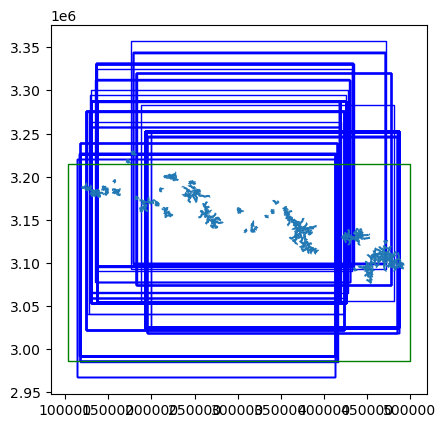

In [180]:
fig, ax = plt.subplots()

center_lines_sub_prj.plot(ax=ax)
gdf_prj.plot(facecolor='None', edgecolor='blue', ax=ax, label = 'retreat data footprints')
nasadem_prj_fp.plot(ax=ax, facecolor='None', edgecolor='green')


Want to have a df with outlines, and one with centerlines for the 90 glaciers

In [181]:
#drop outline geometry
rgi_subset_centerlines = rgi_outlines.drop('geometry', axis=1)

In [182]:
center_lines_subset = center_lines_subset.rename({'GLIMS_ID':'GLIMSId'}, axis=1)

In [183]:
center_lines_subset

,GLIMSId,Type,MaxL,MeanL,ELA,AccL,AblationL,geometry
3391,G086756E28007N,3,11624.0,9653.0,5511,3638.0,7985.0,"MULTILINESTRING ((86.75781 27.99224, 86.75794 ..."
3396,G086581E28097N,3,18436.0,14820.0,5309,6147.0,12289.0,"MULTILINESTRING ((86.57850 28.02072, 86.57859 ..."
3402,G086508E27942N,3,10917.0,9094.0,5409,2459.0,8457.0,"MULTILINESTRING ((86.50374 27.88677, 86.50361 ..."
3409,G086541E27955N,2,7388.0,5933.0,5137,2398.0,4989.0,"MULTILINESTRING ((86.57628 27.95178, 86.57604 ..."
3422,G086534E27875N,3,18675.0,13978.0,5706,5985.0,12690.0,"MULTILINESTRING ((86.54035 27.81372, 86.54035 ..."
...,...,...,...,...,...,...,...,...
10171,G085521E28579N,3,9584.0,7285.0,6041,2046.0,7537.0,"MULTILINESTRING ((85.53241 28.56600, 85.53252 ..."
10177,G085572E28553N,2,6061.0,5180.0,5718,2324.0,3736.0,"MULTILINESTRING ((85.57556 28.55173, 85.57556 ..."
10180,G085618E28467N,3,7453.0,5439.0,5878,5449.0,2004.0,"MULTILINESTRING ((85.64620 28.44723, 85.64601 ..."
10189,G085694E28431N,4,14713.0,13007.0,5840,4050.0,10663.0,"MULTILINESTRING ((85.68622 28.38979, 85.68560 ..."


In [184]:
rgi_subset_centerlines = rgi_subset_centerlines.merge(center_lines_subset, on='GLIMSId')

In [185]:
rgi_subset_centerlines = gpd.GeoDataFrame(rgi_subset_centerlines.iloc[:, :-6], geometry = rgi_subset_centerlines['geometry'])

<AxesSubplot: >

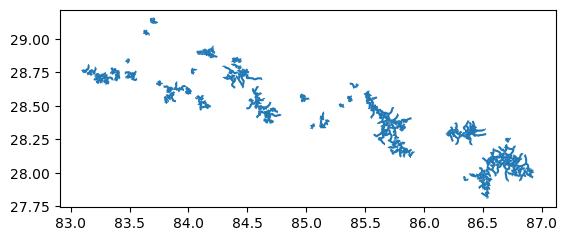

In [186]:
rgi_subset_centerlines.plot()

In [187]:
len(rgi_subset_centerlines['RGIId'].to_list())

110

now, update `rgi_outlines` again:

In [188]:
rgi_outlines = rgi_outlines.loc[rgi_outlines['RGIId'].isin(rgi_subset_centerlines['RGIId'].to_list())]

In [189]:
len(rgi_outlines['RGIId'].to_list())

110

In [190]:
rgi_outlines.crs

<Derived Projected CRS: EPSG:32645>
Name: WGS 84 / UTM zone 45N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°E and 90°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. India. Kazakhstan. Mongolia. Nepal. Russian Federation.
- bounds: (84.0, 0.0, 90.0, 84.0)
Coordinate Operation:
- name: UTM zone 45N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Subset the centerlines df to have only the glaciers in `rgi_outlines`

<AxesSubplot: >

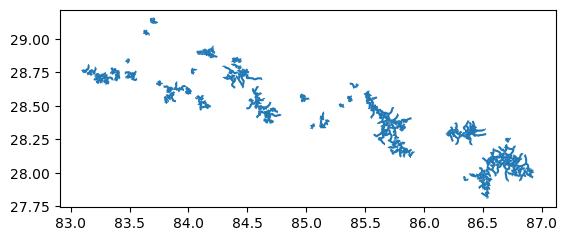

In [191]:
rgi_subset_centerlines.plot()

In [192]:
rgi_subset_centerlines_prj = rgi_subset_centerlines.to_crs('EPSG:32645')

In [328]:
len(rgi_subset_centerlines_prj['RGIId'])
rgi_ids = rgi_subset_centerlines_prj['RGIId'].to_list()

### NASADEM

In [193]:
nasadem_dir = '/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/data/nasadem/'

In [194]:
nasadem = xr.open_dataset(os.path.join(nasadem_dir, 'merged_dem_retreat.nc')).squeeze()

In [195]:
nasadem = nasadem.rio.write_crs('EPSG:4326')

In [196]:
nasadem_prj = nasadem.rio.reproject('EPSG:32645')

In [197]:
nasadem_prj

<xarray.Dataset>
Dimensions:  (x: 14155, y: 8134)
Coordinates:
  * x        (x) float64 1.029e+05 1.03e+05 1.03e+05 ... 4.999e+05 5e+05 5e+05
  * y        (y) float64 3.215e+06 3.215e+06 3.215e+06 ... 2.986e+06 2.986e+06
    crs      int64 0
Data variables:
    Band1    (y, x) float32 nan nan nan nan ... 1.867e+03 1.866e+03 1.859e+03
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 3.5.2, released 2022/09/02
    history:      Thu Mar 23 17:14:27 2023: GDAL Create( /home/emmamarshall/D...

In [198]:
nasadem_prj_fp = retreat_tools.get_footprint(nasadem_prj, crs='EPSG:32645')

In [199]:
rgi_subset_centerlines_prj.crs

<Derived Projected CRS: EPSG:32645>
Name: WGS 84 / UTM zone 45N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°E and 90°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. India. Kazakhstan. Mongolia. Nepal. Russian Federation.
- bounds: (84.0, 0.0, 90.0, 84.0)
Coordinate Operation:
- name: UTM zone 45N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [200]:
rgi09991_cl = rgi_subset_centerlines_prj.loc[rgi_subset_centerlines_prj['RGIId'] == 'RGI60-15.09991']

In [201]:
rgi09991_cl

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Status,Connect,Form,TermType,Surging,Linkages,Name,index_right,Type,geometry
94,RGI60-15.09991,G086830E28048N,20100409,-9999999,86.83,28.048,15,2,73.215,5155,...,0,0,0,0,9,9,CN5O193B0142 Rongbuk Glacier,0,4,"MULTILINESTRING ((490531.361 3097755.587, 4906..."


In [202]:
#glaciers that have less than 100 obs in the seasonal flowline velocity dfs (created in this df, analyzed in eda notebook)
empty_glaciers = [
    'RGI60-15.04415',
     'RGI60-15.04834',
     'RGI60-15.04100',
     'RGI60-15.04833',
     'RGI60-15.03733',
     'RGI60-15.04569',
     'RGI60-15.09991',
     'RGI60-15.03734',
     'RGI60-15.05116',
     'RGI60-15.09965',
     'RGI60-15.04858',
     'RGI60-15.04860',
     'RGI60-15.04438',
     'RGI60-15.04835']

In [203]:
empty_glaciers_cl = rgi_subset_centerlines_prj.loc[rgi_subset_centerlines_prj['RGIId'].isin(empty_glaciers)]

In [204]:
empty_glaciers_df = rgi_outlines.loc[rgi_outlines['RGIId'].isin(empty_glaciers)]

In [205]:
empty_glaciers_df.explore()

<AxesSubplot: >

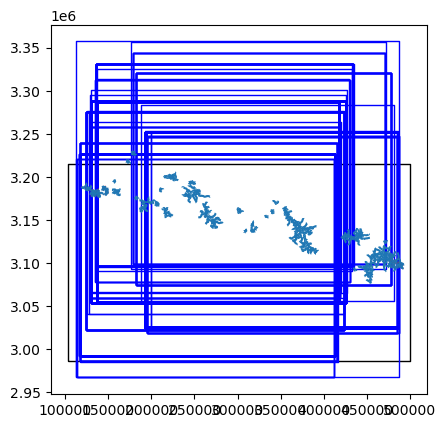

In [206]:
fig, ax = plt.subplots()

nasadem_prj_fp.plot(ax=ax, facecolor='None')
rgi_subset_centerlines_prj.plot(ax=ax)
cube_footprint.plot(ax=ax, facecolor='None', edgecolor = 'blue')
retreat_footprint = gdf_prj.plot(facecolor='None', edgecolor='blue', ax=ax, label = 'retreat data footprints')
empty_glaciers_df.plot(ax=ax, color='red')

## Ind glacier workflow

### Fns

In [207]:
r03976 = rgi_subset_centerlines_prj.loc[rgi_subset_centerlines_prj['RGIId'] == 'RGI60-15.03976']

<AxesSubplot: >

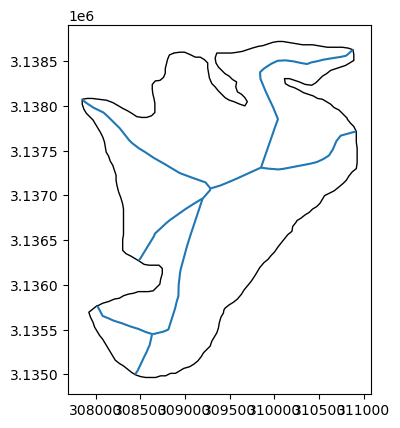

In [208]:
fig ,ax  = plt.subplots()
rgi_outlines.loc[rgi_outlines['RGIId'] == 'RGI60-15.03976'].plot(ax=ax, facecolor='None')
r03976.plot(ax=ax)

In [235]:
rgi04100 = rgi_outlines.loc[rgi_outlines['RGIId'] == 'RGI60-15.04100']

In [236]:
rgi04100

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,index_right
114,RGI60-15.04100,G084578E28497N,20011024,-9999999,84.578135,28.497254,15,1,5.681,5714,...,3320,0,0,0,0,9,9,NaN,"POLYGON ((265283.374 3156519.532, 265277.095 3...",0


In [237]:
ds_04100 = cube.rio.clip(rgi04100.geometry, rgi04100.crs)

In [238]:
ds_04100 = ds_04100.to_dataset(dim='band')

In [239]:
ds_04100

<xarray.Dataset>
Dimensions:         (time: 314, y: 20, x: 18, band: 5)
Coordinates: (12/18)
  * time            (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
    id              (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
  * x               (x) float64 2.616e+05 2.618e+05 ... 2.648e+05 2.65e+05
  * y               (y) float64 3.156e+06 3.156e+06 ... 3.153e+06 3.153e+06
    tile            (time) <U10 '10_085_002' '10_019_001' ... '10_019_085'
    img2_id         (time) <U4 'D1BD' '1CFB' '3910' ... 'F61C' 'D582' '3830'
    ...              ...
    title           (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    epsg            int64 32645
    img1_date       (time) datetime64[ns] 2014-10-11T12:21:55 ... 2021-10-30T...
    img2_date       (time) datetime64[ns] 2014-11-04T12:21:55 ... 2021-11-11T...
    img_separation  (time) float64 -24.0 -24.0 -24.0 -24.0 ... -12.0 -12.0 -12.0
    spatial_ref     int64 0
Dimensions without coordinates: band
Data variables:
    dis_ang         (time, y, x) float64 dask.array<chunksize=(1, 20, 18), meta=np.ndarray>
    dis_az          (time, y, x) float64 dask.array<chunksize=(1, 20, 18), meta=np.ndarray>
    dis_mag         (time, y, x) float64 dask.array<chunksize=(1, 20, 18), meta=np.ndarray>
    dis_N_ang       (time, y, x) float64 dask.array<chunksize=(1, 20, 18), meta=np.ndarray>
    dis_r           (time, y, x) float64 dask.array<chunksize=(1, 20, 18), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

In [240]:
print(ds_04100.isel(time=7).img1_date.values)
print(ds_04100.isel(time=7).time.values)
print(ds_04100.isel(time=7).img2_date.values)
print(ds_04100.isel(time=7).img_separation.values)

2014-12-10T12:21:50.000000000
2014-12-22T00:00:00.000000000
2015-01-03T12:21:50.000000000
-24.0


In [241]:
print(ds_04100.isel(time=8).img1_date.values)
print(ds_04100.isel(time=8).time.values)
print(ds_04100.isel(time=8).img2_date.values)
print(ds_04100.isel(time=8).img_separation.values)

2014-11-28T12:21:54.000000000
2014-12-22T00:00:00.000000000
2015-01-15T12:21:53.000000000
-48.0


### Calculating cov for a single glacier

In [287]:
valid_pixels = ds_04100.dis_mag.count(dim=['x','y'])
valid_pixels_max = ds_04100.dis_mag.notnull().any('time').sum(['x','y'])
ds_04100['cov'] = valid_pixels / valid_pixels_max

In [290]:
valid_pixels_max = ds_04100.dis_mag.notnull().any('time').sum(['x','y'])

In [295]:
ds_04100['cov'] = valid_pixels / valid_pixels_max

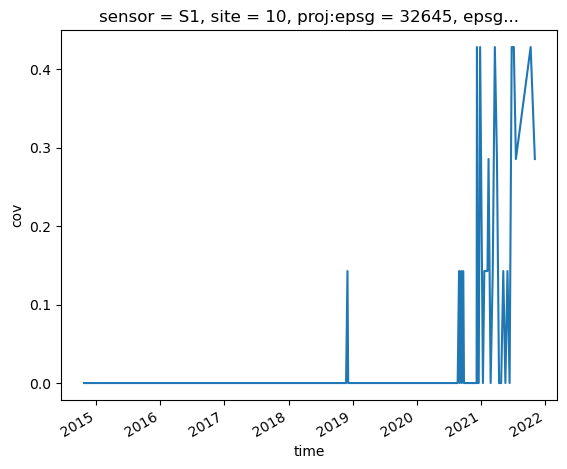

In [297]:
ds_04100.cov.plot()

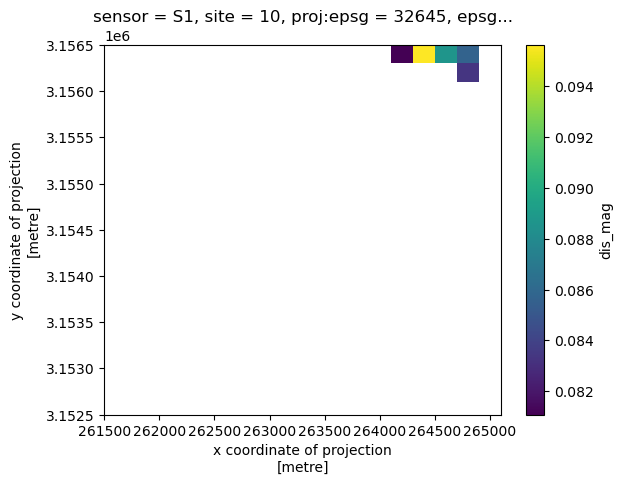

In [242]:
ds_04100.where(ds_04100.img_separation > -20).dis_mag.mean(dim='time').plot()

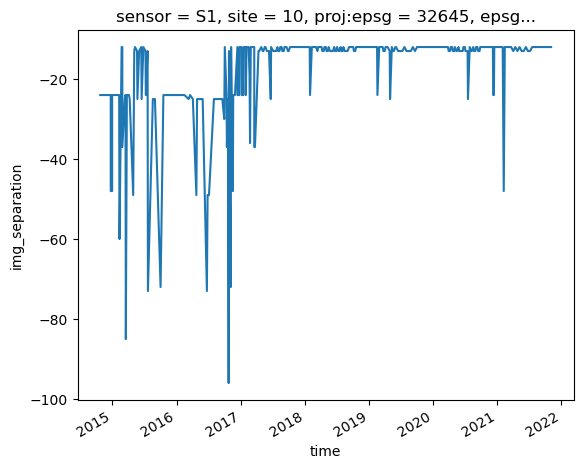

In [243]:
ds_04100.img_separation.plot()

In [274]:
rgi04100.crs

<Derived Projected CRS: EPSG:32645>
Name: WGS 84 / UTM zone 45N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°E and 90°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. India. Kazakhstan. Mongolia. Nepal. Russian Federation.
- bounds: (84.0, 0.0, 90.0, 84.0)
Coordinate Operation:
- name: UTM zone 45N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [256]:
3.152539e+06

3152539.0

In [276]:
cube_sub = cube.sel(x=slice(260000,266000))#, y = slice(3151539.0, 3157550))# & (y=slice(3.151539e+06, 3.157550e+06)))

In [277]:
cube_sub = cube_sub.to_dataset(dim='band')

In [283]:
rgi_outlines.crs

<Derived Projected CRS: EPSG:32645>
Name: WGS 84 / UTM zone 45N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°E and 90°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. India. Kazakhstan. Mongolia. Nepal. Russian Federation.
- bounds: (84.0, 0.0, 90.0, 84.0)
Coordinate Operation:
- name: UTM zone 45N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Missing data

it looks like a number of glaciers have sparse data coverage. visual below. glaciers with less than n data points in the seasonal mean velocity dfs listed above

<AxesSubplot: title={'center': 'sensor = S1, site = 10, proj:epsg = 32645, epsg...'}, xlabel='x', ylabel='y'>

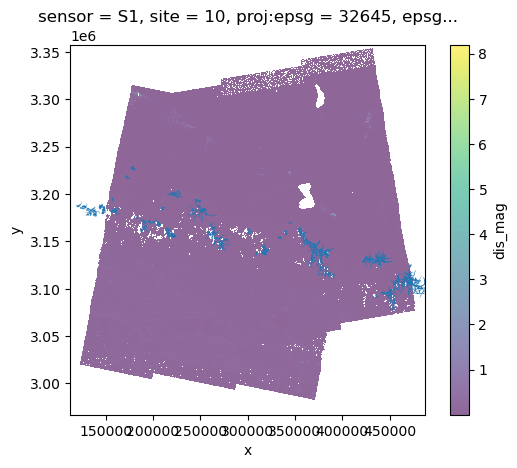

In [286]:
fig, ax = plt.subplots()
cube.to_dataset(dim='band').dis_mag.mean(dim='time').plot(ax=ax, alpha = 0.6)
rgi_outlines.plot(ax=ax)

(3050000.0, 3200000.0)

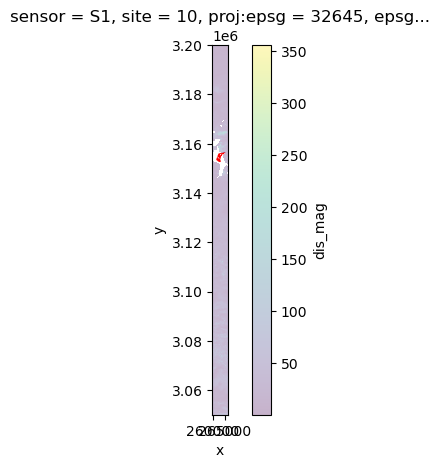

In [282]:
fig, ax = plt.subplots()

rgi04100.plot(ax=ax, color='red')
(cube_sub.dis_mag.mean(dim='time')*365).plot(ax=ax, alpha=  0.3)
ax.set_ylim(3.05e6, 3.2e6)

In [262]:
cube_sub.y.min()
cube_sub.y.max()

<xarray.DataArray 'y' ()>
array(3357000.)
Coordinates:
    sensor     <U2 'S1'
    site       <U2 '10'
    proj:epsg  int64 32645
    epsg       int64 32645

In [263]:
cube_sub = cube.sel(y=slice(3151000, 3158000))

In [264]:
cube_sub

<xarray.DataArray 'stackstac-ba3fcce18eded81b61357e8a9235e83a' (time: 314,
                                                                band: 5, y: 0,
                                                                x: 1875)>
dask.array<getitem, shape=(314, 5, 0, 1875), dtype=float64, chunksize=(1, 1, 0, 1024), chunktype=numpy.ndarray>
Coordinates: (12/18)
  * time            (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
    id              (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
  * band            (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
  * x               (x) float64 1.128e+05 1.13e+05 ... 4.874e+05 4.876e+05
  * y               (y) float64 
    tile            (time) <U10 '10_085_002' '10_019_001' ... '10_019_085'
    ...              ...
    proj:epsg       int64 32645
    title           (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    epsg            int64 32645
    img1_date       (time) datetime64[ns] 2014-10-11T12:21:55 ... 2021-10-30T...
    img2_date       (time) datetime64[ns] 2014-11-04T12:21:55 ... 2021-11-11T...
    img_separation  (time) float64 -24.0 -24.0 -24.0 -24.0 ... -12.0 -12.0 -12.0
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    crs:         epsg:32645
    transform:   | 200.00, 0.00, 112800.00|\n| 0.00,-200.00, 3357000.00|\n| 0...
    resolution:  200.0

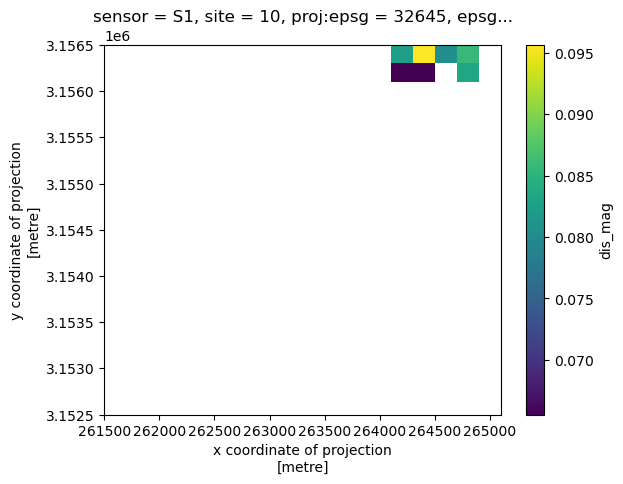

In [98]:
ds_04110.dis_mag.mean(dim='time').plot()

In [62]:
ds_03976 = cube.rio.clip(r03976.geometry, r03976.crs)

In [63]:
ds_03976_ds = ds_03976.to_dataset(dim='band')

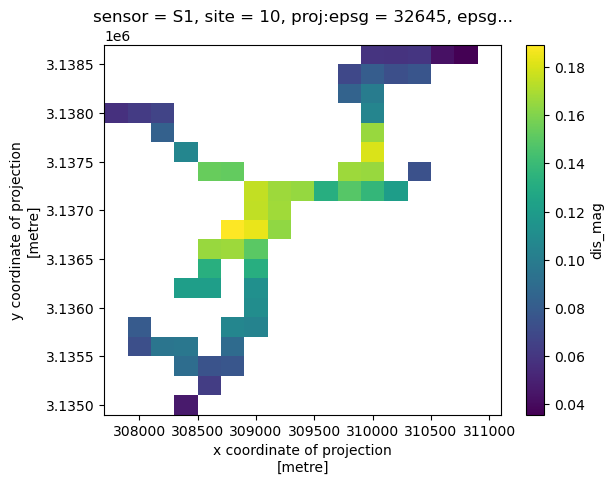

In [64]:
ds_03976_ds.dis_mag.mean(dim='time').plot()

In [353]:
already_made_dfs = os.listdir('/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/prelim_results_centerline/')
already_made_dfs    
    
already_made_glaciers = [already_made_dfs[line][16:-4] for line in range(len(already_made_dfs))]

In [319]:
def clip_glacier_add_dem(rgi_id, rgi_centerline, rgi_outline, retreat_xr, dem_xr): #all in local utm
        
    #if rgi_id in already_made_glaciers:
        
    #    pass
    
    #else: 
        
        try:
        
    
            #make centerline gpdf
            rgi_single_centerline = rgi_centerline.loc[rgi_centerline['RGIId'] == rgi_id]

            #make outline gpdf
            rgi_single_outline = rgi_outline.loc[rgi_outline['RGIId'] == rgi_id]

            #make outline clip
            retreat_clip_outline = retreat_xr.rio.clip(rgi_single_outline.geometry, rgi_single_outline.crs)

            retreat_clip_ds_outline = retreat_clip_outline.to_dataset(dim='band')

            dem_clip_outline = dem_xr.rio.clip(rgi_single_outline.geometry, rgi_single_outline.crs)

            dem_downsamp_outline = dem_clip_outline.interp_like(retreat_clip_ds_outline, method = 'nearest')

            #$flowline_obj = retreat_clip_ds.rio.clip(glacier_obj.ablationLine.geometry, glacier_gb.v.rio.crs)

            retreat_clip_ds_outline['sem_mag'] = (('time'), [retreat_tools.calc_sem(retreat_clip_ds_outline.isel(time=t).dis_mag.data) for t in range(len(retreat_clip_ds_outline.time))])

            retreat_clip_ds_outline['z'] = dem_downsamp_outline.Band1

            retreat_clip_centerline = retreat_clip_ds_outline.rio.clip(rgi_single_centerline.geometry, rgi_single_centerline.crs)

            retreat_clip_centerline['dis_mag_my'] = retreat_clip_centerline.dis_mag * 365
            
            valid_pixels = retreat_clip_centerline.dis_mag.count(dim=['x','y'])
            valid_pixels_max = retreat_clip_centerline.dis_mag.notnull().any('time').sum(['x','y'])
            retreat_clip_centerline['cov'] = valid_pixels / valid_pixels_max
    
            gb = retreat_clip_centerline.groupby(retreat_clip_centerline.time.dt.season).mean()

            df = gb[['dis_mag_my','z']].to_dataframe()

            df = df.reset_index(level=0)

            df['RGIId'] = rgi_id

            df[['season','dis_mag_my','z']]

            #df.to_csv(f'/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/prelim_results_centerline/v_z_seasonal_df_{rgi_id}.csv')
            return retreat_clip_centerline
        except:
            print(rgi_id)

                                  

In [320]:
cl_03976 = clip_glacier_add_dem('RGI60-15.03976', rgi_subset_centerlines_prj, rgi_outlines, cube, nasadem_prj)

In [332]:
len(rgi_ids)
xr_ls = [] 
for glacier in rgi_ids:
    
    ds = clip_glacier_add_dem(glacier, rgi_subset_centerlines_prj, rgi_outlines, cube, nasadem_prj)
    xr_ls.append(ds)
xr_dict = dict(zip(rgi_ids, xr_ls))

/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xar

RGI60-15.04929
RGI60-15.04998


/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xar

In [334]:
xr_dict.keys()

dict_keys(['RGI60-15.03417', 'RGI60-15.03422', 'RGI60-15.03428', 'RGI60-15.03435', 'RGI60-15.03448', 'RGI60-15.03473', 'RGI60-15.03474', 'RGI60-15.03733', 'RGI60-15.03734', 'RGI60-15.03744', 'RGI60-15.03976', 'RGI60-15.03986', 'RGI60-15.04060', 'RGI60-15.04070', 'RGI60-15.04071', 'RGI60-15.04098', 'RGI60-15.04100', 'RGI60-15.04101', 'RGI60-15.04118', 'RGI60-15.04119', 'RGI60-15.04121', 'RGI60-15.04137', 'RGI60-15.04149', 'RGI60-15.04151', 'RGI60-15.04176', 'RGI60-15.04220', 'RGI60-15.04230', 'RGI60-15.04258', 'RGI60-15.04415', 'RGI60-15.04438', 'RGI60-15.04442', 'RGI60-15.04474', 'RGI60-15.04515', 'RGI60-15.04541', 'RGI60-15.04568', 'RGI60-15.04569', 'RGI60-15.04600', 'RGI60-15.04611', 'RGI60-15.04631', 'RGI60-15.04653', 'RGI60-15.04676', 'RGI60-15.04679', 'RGI60-15.04714', 'RGI60-15.04717', 'RGI60-15.04719', 'RGI60-15.04757', 'RGI60-15.04763', 'RGI60-15.04766', 'RGI60-15.04768', 'RGI60-15.04785', 'RGI60-15.04789', 'RGI60-15.04793', 'RGI60-15.04813', 'RGI60-15.04830', 'RGI60-15.04833',

In [338]:
def calc_cov(ds):
    
    #subset by coverage
    valid_pixels = ds.dis_mag.count(dim=['x','y'])
    valid_pixels_max = ds.dis_mag.notnull().any('time').sum(['x','y'])
    ds['cov'] = valid_pixels / valid_pixels_max
    ds = ds.where(ds.cov >= 0.5, drop=True)
    #subset to make sure img1 and img2 in same season
    ds = ds.where(ds.img1_date == ds.img2_date, drop=True)
    
    return ds

In [ ]:
for glacier in xr_dict.keys():
    
    xr_dict[glacier] = calc_cov(xr_dict[glacier])

/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [335]:
xr_dict['RGI60-15.03417']

<xarray.Dataset>
Dimensions:         (time: 314, x: 39, y: 31)
Coordinates: (12/18)
  * time            (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
    id              (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
  * x               (x) float64 4.71e+05 4.712e+05 ... 4.784e+05 4.786e+05
  * y               (y) float64 3.101e+06 3.101e+06 ... 3.095e+06 3.095e+06
    tile            (time) <U10 '10_085_002' '10_019_001' ... '10_019_085'
    img2_id         (time) <U4 'D1BD' '1CFB' '3910' ... 'F61C' 'D582' '3830'
    ...              ...
    epsg            int64 32645
    img1_date       (time) datetime64[ns] 2014-10-11T12:21:55 ... 2021-10-30T...
    img2_date       (time) datetime64[ns] 2014-11-04T12:21:55 ... 2021-11-11T...
    img_separation  (time) float64 -24.0 -24.0 -24.0 -24.0 ... -12.0 -12.0 -12.0
    crs             int64 0
    spatial_ref     int64 0
Data variables:
    dis_ang         (time, y, x) float64 dask.array<chunksize=(1, 31, 39), meta=np.ndarray>
    dis_az          (time, y, x) float64 dask.array<chunksize=(1, 31, 39), meta=np.ndarray>
    dis_mag         (time, y, x) float64 dask.array<chunksize=(1, 31, 39), meta=np.ndarray>
    dis_N_ang       (time, y, x) float64 dask.array<chunksize=(1, 31, 39), meta=np.ndarray>
    dis_r           (time, y, x) float64 dask.array<chunksize=(1, 31, 39), meta=np.ndarray>
    sem_mag         (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    z               (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    dis_mag_my      (time, y, x) float64 dask.array<chunksize=(1, 31, 39), meta=np.ndarray>
    cov             (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

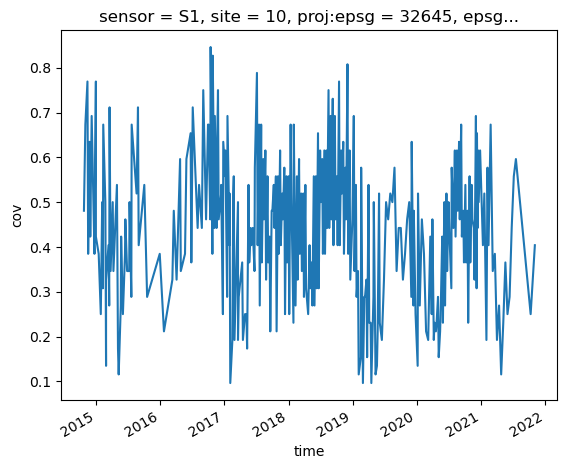

In [322]:
cl_03976.cov.plot()

In [335]:
cl_03976.loc[cl_03976['season'] == 'DJF']['dis_mag_my'].mean()

42.02820375851344

In [ ]:
df_all = pd.concat([clip_glacier_add_dem(rgi_id, rgi_subset_centerlines_prj, rgi_outlines, cube, nasadem_prj) for rgi_id in rgi_outlines['RGIId'].to_list()])

RGI60-15.04929
RGI60-15.04998


/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xar

In [177]:
gb_03976 = cl_03976.groupby(cl_03976.time.dt.season).mean()

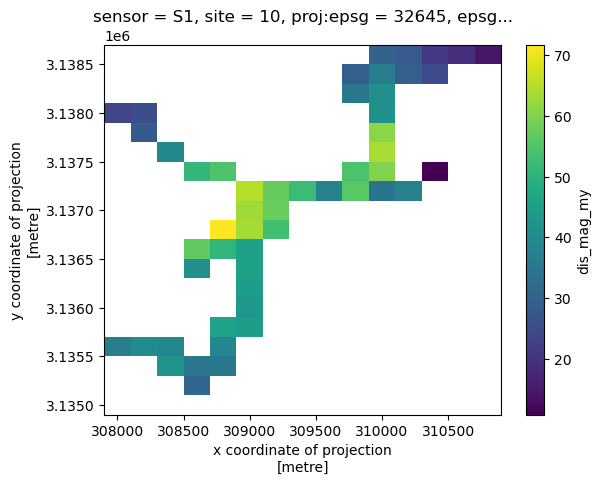

In [188]:
gb_03976.sel(season='DJF').dis_mag_my.plot()

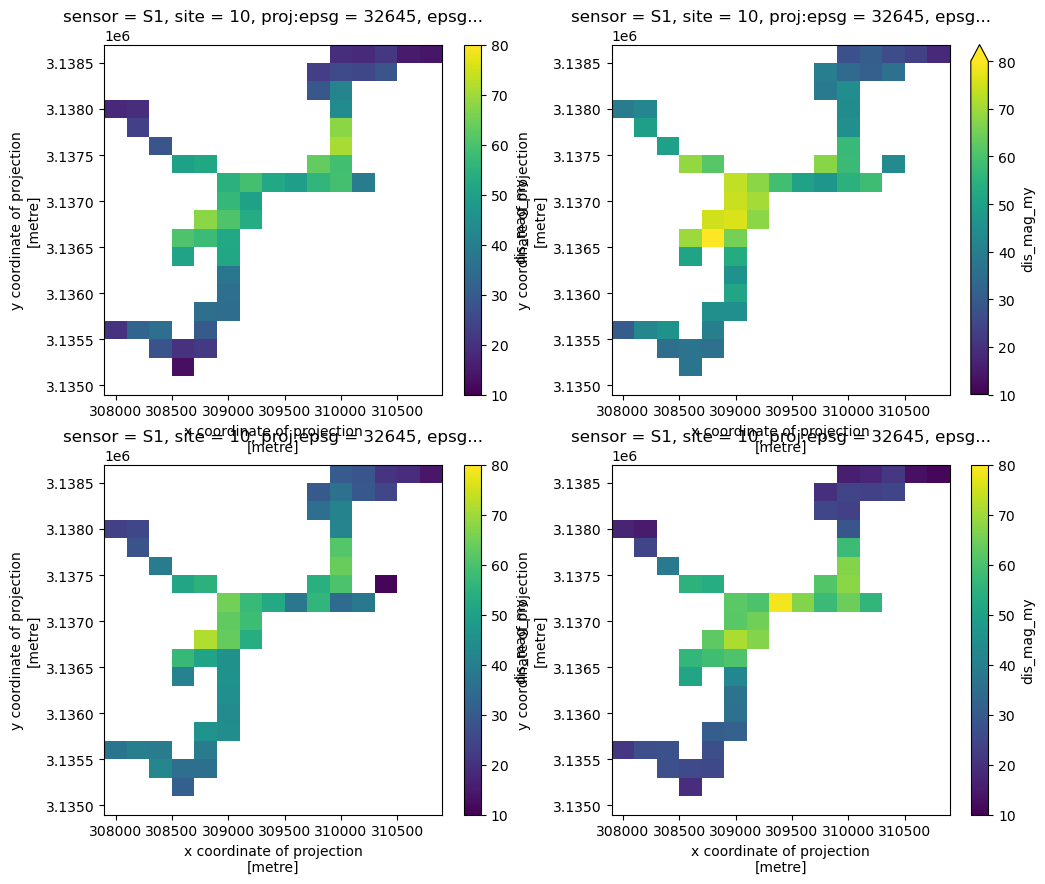

In [190]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,10))

gb_03976.sel(season='SON').dis_mag_my.plot(ax=axs[0][0], vmin=10, vmax=80)
gb_03976.sel(season='DJF').dis_mag_my.plot(ax=axs[1][0],  vmin=10, vmax=80)

gb_03976.sel(season='MAM').dis_mag_my.plot(ax=axs[0][1],  vmin=10, vmax=80)
gb_03976.sel(season='JJA').dis_mag_my.plot(ax=axs[1][1],  vmin=10, vmax=80);

In [195]:
df_03976 = gb_03976[['dis_mag_my','z']].to_dataframe()

In [327]:
df_03976[['season','dis_mag_my','z']]['RGIId'] = ['RGI60-13.03976' for i in range(len(df_03976['z']))]

/scratch/local/u1269862/7343030/ipykernel_2730197/2929078212.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_03976[['season','dis_mag_my','z']]['RGIId'] = ['RGI60-13.03976' for i in range(len(df_03976['z']))]


In [201]:
import seaborn as sns

<AxesSubplot: xlabel='z', ylabel='dis_mag_my'>

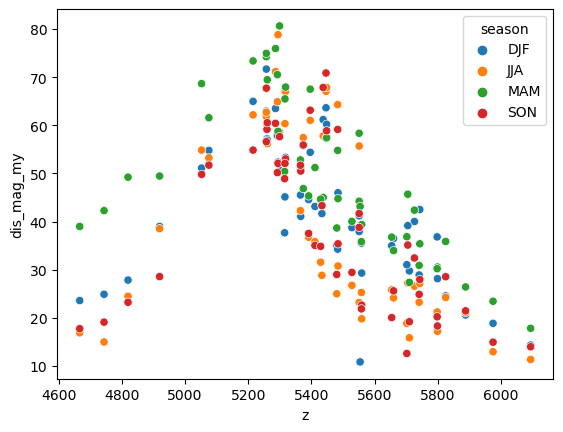

In [202]:
sns.scatterplot(data=df_03976, x='z',y='dis_mag_my', hue='season')

<AxesSubplot: xlabel='z', ylabel='dis_mag_my'>

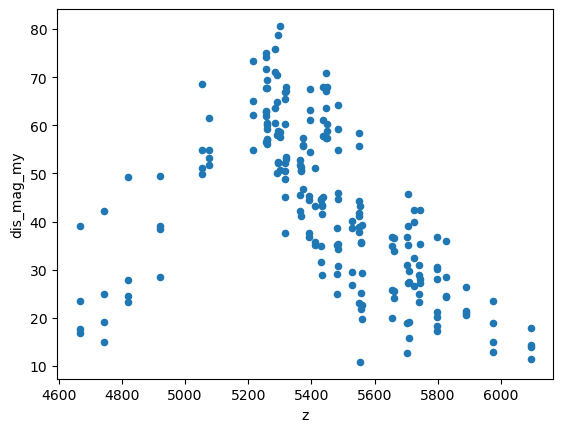

In [197]:
df_03976.plot.scatter(x='z',y='dis_mag_my')

In [199]:
df_03976 = df_03976.reset_index(level=0)

In [200]:
df_03976

season  dis_mag_my   z sensor site  proj:epsg   epsg  crs  \
y         x                                                                    
3138600.0 308000.0    DJF         NaN NaN     S1   10      32645  32645    0   
          308200.0    DJF         NaN NaN     S1   10      32645  32645    0   
          308400.0    DJF         NaN NaN     S1   10      32645  32645    0   
          308600.0    DJF         NaN NaN     S1   10      32645  32645    0   
          308800.0    DJF         NaN NaN     S1   10      32645  32645    0   
...                   ...         ...  ..    ...  ...        ...    ...  ...   
3135000.0 310000.0    SON         NaN NaN     S1   10      32645  32645    0   
          310200.0    SON         NaN NaN     S1   10      32645  32645    0   
          310400.0    SON         NaN NaN     S1   10      32645  32645    0   
          310600.0    SON         NaN NaN     S1   10      32645  32645    0   
          310800.0    SON         NaN NaN     S1   10      32645  32645    0   

                    spatial_ref  
y         x                      
3138600.0 308000.0            0  
          308200.0            0  
          308400.0            0  
          308600.0            0  
          308800.0            0  
...                         ...  
3135000.0 310000.0            0  
          310200.0            0  
          310400.0            0  
          310600.0            0  
          310800.0            0  

[1140 rows x 9 columns]